### 低开销编译器
DEAP在编译GP时使用了Python的默认编译器，但是Python默认编译器在编译GP时实际上速度较慢，因此我们可以考虑自行实现一个编译器来加速GP运算。更严格来说，应该是自行实现一个GP树的解析函数，从而降低编译的时间开销。

In [1]:
import time
import warnings

import numpy as np
from deap import base, creator, tools, gp
from deap.gp import PrimitiveTree, Primitive, Terminal

warnings.filterwarnings("ignore")


def quick_evaluate(expr: PrimitiveTree, pset, data, prefix='ARG'):
    result = None
    stack = []
    for node in expr:
        stack.append((node, []))
        while len(stack[-1][1]) == stack[-1][0].arity:
            prim, args = stack.pop()
            if isinstance(prim, Primitive):
                result = pset.context[prim.name](*args)
            elif isinstance(prim, Terminal):
                if prefix in prim.name:
                    result = data[:, int(prim.name.replace(prefix, ''))]
                else:
                    result = prim.value
            else:
                raise Exception
            if len(stack) == 0:
                break  # 栈为空代表所有节点都已经被访问
            stack[-1][1].append(result)
    return result


# 符号回归
def evalSymbReg(individual, pset):
    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100).reshape(-1, 1)

    # 评估生成的函数并计算MSE
    mse = np.mean((quick_evaluate(individual, pset, x) - x ** 2) ** 2)

    return (mse,)


# 创建个体和适应度函数
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

In [3]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用默认算法
custom_compiler_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log = algorithms.eaSimple(population=population,
                                   toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof,
                                   verbose=True)
    end = time.time()
    print('time:', end - start)
    print(str(hof[0]))
    custom_compiler_time.append(end - start)

   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max        	min    	nevals	std        	avg 	gen	max	min	nevals	std    
0  	100   	121165	0  	1.18875e+07	1849.78	100   	1.18256e+06	3.88	0  	7  	2  	100   	1.45794
1  	92    	5608.85	1  	187844     	1849.78	92    	23462.3    	4.2 	1  	13 	2  	92    	1.92873
2  	91    	5064.47	2  	153712     	1849.78	91    	21235.6    	4.42	2  	10 	2  	91    	1.69222
3  	92    	11535  	3  	608604     	1849.78	92    	63855.3    	4.92	3  	11 	2  	92    	1.91144
4  	86    	239906 	4  	1.18875e+07	1849.78	86    	1.66394e+06	5.08	4  	11 	2  	86    	2.00838
5  	88    	15739.1	5  	157411     	1849.78	88    	43218.6    	5.35	5  	11 	2  	88    	2.20624
6  	86    	125529 	6  	1.21905e+07	1849.78	86    	1.21267e+06	5.42	6  	11 	2  	86    	2.31594
7  	92    	5

In [4]:
# 慢速评估
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)

    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100)

    # 评估生成的函数并计算MSE
    mse = np.mean((func(x) - x ** 2) ** 2)

    return (mse,)


toolbox.register("evaluate", evalSymbReg, pset=pset)

py_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log = algorithms.eaSimple(population=population,
                                   toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof,
                                   verbose=True)
    end = time.time()
    print('time:', end - start)
    py_time.append(end - start)

   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max        	min	nevals	std        	avg	gen	max	min	nevals	std    
0  	100   	119447	0  	1.17257e+07	0  	100   	1.16648e+06	4.2	0  	7  	2  	100   	1.73781
1  	94    	1603.85	1  	2387.41    	0  	94    	878.039    	4.53	1  	12 	2  	94    	2.01224
2  	94    	4695.69	2  	153712     	0  	94    	21352.2    	4.67	2  	9  	2  	94    	1.93419
3  	94    	10059.5	3  	157909     	0  	94    	36398.7    	4.46	3  	11 	2  	94    	2.16527
4  	90    	5346.64	4  	159956     	0  	90    	26380.6    	4.66	4  	11 	3  	90    	2.24597
5  	90    	12550.5	5  	153712     	0  	90    	41327.4    	4.44	5  	9  	2  	90    	2.11339
6  	95    	11218.5	6  	153712     	0  	95    	38956.6    	4.07	6  	9  	3  	95    	1.79586
7  	93    	123617 	7  	1.23323e+07	0  	93    	

下图展示了实验结果，从实验结果可以看出，自行实现的编译器在编译GP树时的速度要快于Python默认编译器。主要是因为自行实现的编译器基本没有额外开销，而Python默认编译器在编译时会进行一些额外的操作，因此速度较慢。

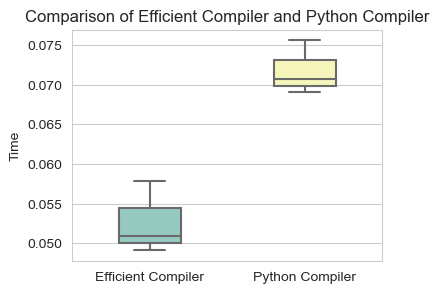

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame(
    {'Category': ['Efficient Compiler'] * len(custom_compiler_time) + ['Python Compiler'] * len(py_time),
     'Time': np.concatenate([custom_compiler_time, py_time])})

plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
sns.boxplot(data=data, x='Category', y='Time', palette="Set3", width=0.4)
plt.title('Comparison of Efficient Compiler and Python Compiler')
plt.xlabel('')
plt.ylabel('Time')
plt.show()